In [1]:
# Lets import the library and read the dataset
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install openpyxl

        
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df_ = pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx", sheet_name = "Year 2010-2011" )
df = df_.copy()
df.head()

     |████████████████████████████████| 243 kB 822 kB/s 


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


**Data Understanding and Preprocessing**

In [2]:
df.shape

(541910, 8)

In [3]:
# Are there any missing values?
df.isnull().any()
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [4]:
# Filling in missing data
df.dropna(inplace=True)

In [5]:
# Check again
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

*How many unique product are there?*

In [6]:
df["StockCode"].nunique()

3684

*How many of each product are there?*

In [7]:
df["StockCode"].value_counts().head()


85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
Name: StockCode, dtype: int64

*Sort the 5 most ordered products from most to least.*

In [8]:
df["StockCode"].value_counts().sort_values(ascending=False).head()

85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
Name: StockCode, dtype: int64

*The 'C' in the invoices shows the canceled transactions. Since we will not use the canceled transactions, we should remove them.*

In [9]:
df = df[~df["Invoice"].str.contains("C", na = False)]

*Create a variable named 'TotalPrice' that represents the total earnings per invoice.*

In [10]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34


**Calculation of RFM metrics**

**Recency :** the number of days between today_date and the last purchase date of this customer

**Frequency :** the number of purchase of this customer

**Monetary :** sum of TotalPrice of this customer

In [12]:
# the last date of purchase
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [13]:
# make sure that none of the Recency values become zero
import datetime as dt
today_date = dt.datetime(2011, 12, 11)

In [14]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


In [15]:
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.00,326,1,77183.60
12347.00,3,7,4310.00
12348.00,76,4,1797.24
12349.00,19,1,1757.55
12350.00,311,1,334.40


*InvoiceDate represent to 'recency'
Invoice represent 'frequency'
TotalPrice represent 'monetary'*

**Lets change the columns names**

In [16]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [17]:
rfm = rfm[rfm["monetary"] > 0]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.00,326,1,77183.60
12347.00,3,7,4310.00
12348.00,76,4,1797.24
12349.00,19,1,1757.55
12350.00,311,1,334.40


We need to score these values between 1 and 5. After scoring, we will segment it.

In [18]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])


rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])


rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [19]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.00,326,1,77183.60,1,1,5,11
12347.00,3,7,4310.00,5,5,5,55
12348.00,76,4,1797.24,2,4,4,24
12349.00,19,1,1757.55,4,1,4,41
12350.00,311,1,334.40,1,1,2,11


In [20]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}


rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12346.00,326,1,77183.60,1,1,5,11,hibernating
12347.00,3,7,4310.00,5,5,5,55,champions
12348.00,76,4,1797.24,2,4,4,24,at_Risk
12349.00,19,1,1757.55,4,1,4,41,promising
12350.00,311,1,334.40,1,1,2,11,hibernating


Now, we anayze 3 segments which are champions, can't loose and need attention.

In [21]:
champions = rfm[rfm['segment'] == 'champions']
cant_loose = rfm[rfm['segment'] == 'cant_loose']

In [22]:
champions[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,6.36,12.42,6857.96
count,633.00,633.00,633.00


We can say that 633 customers bought 6857.96 units by shopping 12 times approximately every 6 days.
It is the most special, most loved type of customer. Special calls can be made to these customers. Gift voucher can be defined. Campaigns can be made of buy 1 get 1 free.

In [23]:
cant_loose[['recency','frequency','monetary']].agg(['mean', 'count'])

,recency,frequency,monetary
mean,132.97,8.38,2796.16
count,63.00,63.00,63.00


63 customers bought 897.63 units by shopping twice every 132 days. They spend a good amount of money and they used to be our loyal customers, we can't loose them. There may be pop-ups like we miss you. Continuous reminder notifications can be sent. Special campaigns can be made for your previous shopping.

In [24]:
loyal_df = pd.DataFrame()
loyal_df["loyal_customer_id"] = rfm[rfm["segment"] == "loyal_customers"].index
loyal_df.head()

loyal_df.to_excel("loyal_customers.xlsx", sheet_name='Loyal Customers Index')

***NOW, USING K-MEANS CLUSTERING***

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import datetime as dt

Scale the data

In [26]:
sc = MinMaxScaler((0, 1))
segment_df = pd.DataFrame(sc.fit_transform(rfm[["recency", "frequency", "monetary"]]),
                            index=rfm.index, columns=["Recency", "Frequency", "Monetary"])
segment_df.reset_index(inplace=True)
segment_df.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.00,0.87,0.00,0.28
1,12347.00,0.01,0.03,0.02
2,12348.00,0.20,0.01,0.01
3,12349.00,0.05,0.00,0.01
4,12350.00,0.83,0.00,0.00


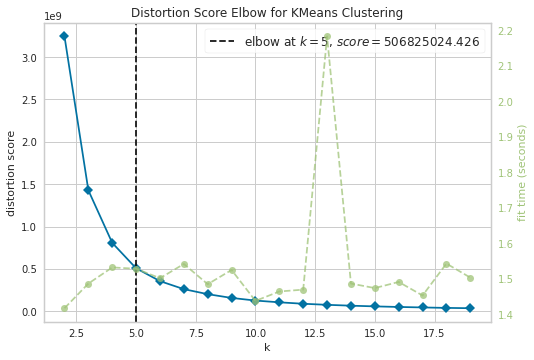

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(segment_df)
elbow.show()

In [28]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(segment_df)
segment_df["clusters"] = kmeans.labels_

In [29]:
segment_df.head()

,Customer ID,Recency,Frequency,Monetary,clusters
0,12346.00,0.87,0.00,0.28,1
1,12347.00,0.01,0.03,0.02,1
2,12348.00,0.20,0.01,0.01,1
3,12349.00,0.05,0.00,0.01,1
4,12350.00,0.83,0.00,0.00,1


**Comparing RFM metrics with K-Means**

In [30]:
segmentation = rfm.merge(segment_df, on="Customer ID")
segmentation[["segment", "clusters", "recency", "frequency", "monetary"]].groupby(["clusters", "segment"]).agg(["mean"])

recency frequency monetary
                                mean      mean     mean
clusters segment                                       
0        about_to_sleep        52.37      1.00   336.46
         at_Risk              165.65      2.82  1480.93
         cant_loose           135.42      8.92  2775.26
         champions              6.96     13.49  7304.46
         hibernating          222.38      1.00   331.13
         loyal_customers       35.87      6.74  2562.75
         need_attention        52.19      2.40   735.55
         new_customers          7.75      1.00   651.72
         potential_loyalists   17.19      2.25   792.15
         promising             23.97      1.00   277.57
1        about_to_sleep        55.27      1.42   750.58
         at_Risk              115.28      3.55  1450.53
         cant_loose           158.62      7.00  4280.72
         champions              6.12     13.88  5439.03
         hibernating          206.72      1.28   879.03
         loyal_customers       31.86      7.30  5037.82
         need_attention        52.62      3.00  2281.44
         new_customers          7.22      1.00   316.04
         potential_loyalists   17.01      2.41   987.07
         promising             23.23      1.00   347.70
2        about_to_sleep        51.76      1.00   294.30
         at_Risk              159.66      2.73   791.58
         cant_loose           156.21      9.29  2320.34
         champions              6.11     12.37  9037.83
         hibernating          228.99      1.00   305.61
         loyal_customers       33.84      6.11  2045.75
         need_attention        49.16      2.00   601.39
         potential_loyalists   17.56      1.54   410.84
3        about_to_sleep        52.26      1.24   444.38
         at_Risk              154.97      2.84  1002.22
         cant_loose           108.46      7.38  2241.67
         champions              6.44     12.40  8070.12
         hibernating          218.38      1.13   390.40
         loyal_customers       31.29      6.58  2483.68
         need_attention        55.33      2.44   890.56
         new_customers          7.42      1.00   232.96
         potential_loyalists   16.56      2.40   847.68
         promising             23.22      1.00   254.28
4        about_to_sleep        53.73      1.00   370.65
         at_Risk              153.53      2.78   852.87
         cant_loose           117.88      8.69  2936.40
         champions              6.30     10.11  4252.10
         hibernating          217.14      1.00   345.33
         loyal_customers       34.59      5.95  2510.58
         need_attention        51.03      2.00   776.84
         potential_loyalists   18.57      1.58  2301.45

In [31]:
pd.DataFrame(segmentation[["segment", "clusters"]].groupby(["clusters", "segment"])["segment"].agg("count"))

segment
clusters segment                     
0        about_to_sleep            67
         at_Risk                  141
         cant_loose                12
         champions                102
         hibernating              202
         loyal_customers          152
         need_attention            53
         new_customers             12
         potential_loyalists       97
         promising                 36
1        about_to_sleep            96
         at_Risk                   67
         cant_loose                 8
         champions                128
         hibernating              289
         loyal_customers          145
         need_attention            16
         new_customers             18
         potential_loyalists       98
         promising                 31
2        about_to_sleep            50
         at_Risk                  137
         cant_loose                14
         champions                129
         hibernating              185
         loyal_customers          174
         need_attention            31
         potential_loyalists      114
3        about_to_sleep            72
         at_Risk                  115
         cant_loose                13
         champions                149
         hibernating              210
         loyal_customers          143
         need_attention            54
         new_customers             12
         potential_loyalists       82
         promising                 27
4        about_to_sleep            67
         at_Risk                  133
         cant_loose                16
         champions                125
         hibernating              185
         loyal_customers          205
         need_attention            33
         potential_loyalists       93